In [1]:
import sys
sys.path.append("../")

import os
%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from scipy import stats
import engarde.decorators as ed

#from library import test

In [2]:
data_path = '/Users/kylieleblancKylie/domino/dofis/data/'
table_path = '/Users/kylieleblancKylie/domino/dofis/results/impact/'
data = pd.read_csv(os.path.join(data_path, 'clean', 'gdid.csv'),
                  sep=",", low_memory= False)
#@ed.verify(test.allyearsandtpsd)
#def load():
 #   return data
#data = load()
#data[['distname', 'year', 'doi_year', 'treat', 'year_centered', 'students_hisp', 'students_num']][data.doi == True].head()

In [4]:
data[data.doi == False][['distname','doi', 'doi_year', 'year', 'treatpost']].head()

,distname,doi,doi_year,year,treatpost
0,A W BROWN-FELLOWSHIP LEADERSHIP AC,False,NaN,2012,False
1,A W BROWN-FELLOWSHIP LEADERSHIP AC,False,NaN,2012,False
2,A+ ACADEMY,False,NaN,2012,False
44,ACADEMY OF ACCELERATED LEARNING IN,False,NaN,2012,False
45,ACADEMY OF CAREERS AND TECHNOLOGIE,False,NaN,2012,False


In [5]:
data[data.year == 2014].doi_year.value_counts().sort_index()

2015.0       1
2016.0     923
2017.0    4205
2018.0     942
2019.0     202
Name: doi_year, dtype: int64

# Graph by year of implementation

In [17]:
def create_group_df(df):
    new_df = pd.DataFrame(df.groupby(['year']).agg({'avescores': ['mean', 'sem']}))
    new_df = new_df.rename(columns = {'mean': 'score_mean', 'sem': 'score_se'})
    new_df['ub'] = new_df['avescores']['score_mean'] + new_df['avescores']['score_se']
    new_df['lb'] = new_df['avescores']['score_mean'] - new_df['avescores']['score_se']
    return new_df
df_treat2016 = create_group_df(data[data.doi_year == 2016])
df_treat2017 = create_group_df(data[data.doi_year == 2017])
df_treat2018 = create_group_df(data[data.doi_year == 2018])
df_charter = create_group_df(data[data.distischarter == 'Y'])
df_treat2016

avescores                  ub        lb
     score_mean  score_se                    
year                                         
2012   0.050793  0.031254  0.082047  0.019539
2013   0.077618  0.032845  0.110463  0.044773
2014   0.115939  0.033330  0.149269  0.082609
2015   0.118642  0.033268  0.151910  0.085373
2016   0.294747  0.034080  0.328827  0.260667
2017   0.314032  0.036353  0.350385  0.277679
2018   0.399069  0.034802  0.433872  0.364267
2019   0.516416  0.034756  0.551172  0.481660

# Full Set of Years and Groups

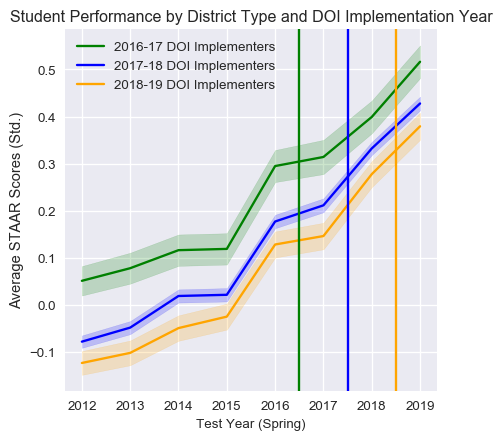

In [20]:
plt.style.use('seaborn')
my_dpi=96
plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)
years = [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019] 
# Pre
#plt.plot(list(df_charter.index), df_charter['avescores']['score_mean'], color = 'yellow', label = 'Charter')
plt.plot(list(df_treat2016.index), df_treat2016['avescores']['score_mean'], color = 'green', label = '2016-17 DOI Implementers')
plt.plot(list(df_treat2017.index), df_treat2017['avescores']['score_mean'], color = 'blue', label = '2017-18 DOI Implementers')
plt.plot(list(df_treat2018.index), df_treat2018['avescores']['score_mean'], color = 'orange', label = '2018-19 DOI Implementers')

plt.legend()


plt.fill_between(list(df_treat2016.index), df_treat2016.lb, df_treat2016.ub, color = 'green', alpha = .2)
plt.fill_between(list(df_treat2017.index), df_treat2017.lb, df_treat2017.ub, color = 'blue', alpha = .2)
plt.fill_between(list(df_treat2018.index), df_treat2018.lb, df_treat2018.ub, color = 'orange', alpha = .2)

plt.axvline(x = 2016.5, color = 'green')
plt.axvline(x = 2017.5, color = 'blue')
plt.axvline(x = 2018.5, color = 'orange')



plt.ylabel('Average STAAR Scores (Std.)')
plt.title('Student Performance by District Type and DOI Implementation Year')
plt.xlabel('Test Year (Spring)', size = 'medium')


plt.savefig(table_path + 'all districts and dates.png', dpi = 600, bbox_inches="tight")
plt.show()

# Evidence of Parallel Trends

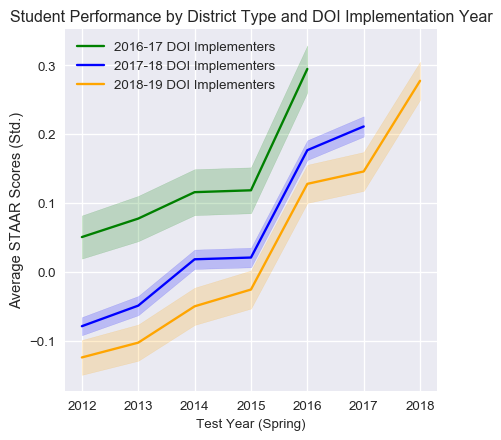

In [22]:
plt.style.use('seaborn')
my_dpi=96
plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)

# Pre
plt.plot(list(df_treat2016[df_treat2016.index <= 2016].index), df_treat2016[df_treat2016.index <= 2016]['avescores']['score_mean'], color = 'green', label = '2016-17 DOI Implementers')
plt.plot(list(df_treat2017[df_treat2017.index <= 2017].index), df_treat2017[df_treat2017.index <= 2017]['avescores']['score_mean'], color = 'blue', label = '2017-18 DOI Implementers')
plt.plot(list(df_treat2018[df_treat2018.index <= 2018].index), df_treat2018[df_treat2018.index <= 2018]['avescores']['score_mean'], color = 'orange', label = '2018-19 DOI Implementers')

plt.legend()

plt.fill_between(list(df_treat2016[df_treat2016.index <= 2016].index), df_treat2016[df_treat2016.index <= 2016].lb, df_treat2016[df_treat2016.index <= 2016].ub, color = 'green', alpha = .2)
plt.fill_between(list(df_treat2017[df_treat2017.index <= 2017].index), df_treat2017[df_treat2017.index <= 2017].lb, df_treat2017[df_treat2017.index <= 2017].ub, color = 'blue', alpha = .2)
plt.fill_between(list(df_treat2018[df_treat2018.index <= 2018].index), df_treat2018[df_treat2018.index <= 2018].lb, df_treat2018[df_treat2018.index <= 2018].ub, color = 'orange', alpha = .2)


plt.ylabel('Average STAAR Scores (Std.)')
plt.title('Student Performance by District Type and DOI Implementation Year')
plt.xlabel('Test Year (Spring)', size = 'medium')

plt.savefig(table_path + 'parallel_trends_by_adoption.png', bbox_inches="tight")

plt.show()

# Weighted Parallel Trends

In [11]:
total_weight_TPSD = sum(data[data.treat == 0].psweight2)
total_weight_DOI16 = sum(data[data.doi_year == 2016].psweight2)
total_weight_DOI17 = sum(data[data.doi_year == 2017].psweight2)
total_weight_DOI18 = sum(data[data.doi_year == 2018].psweight2)
data['pswtshare2'] = np.where(data.treat == 0, (data.psweight2/total_weight_TPSD),
                          np.where(data.doi_year == 2016,(data.psweight2/total_weight_DOI16),
                          np.where(data.doi_year == 2017, (data.psweight2/total_weight_DOI17), 
                                  np.where(data.doi_year == 2018, (data.psweight2/total_weight_DOI18), 0))))
sum(data[data.doi == False].pswtshare2)
data['score_weighted'] = (data.avescores * data.pswtshare2)
data[data.doi == False][['distname','avescores', 'pswtshare2', 'score_weighted']].head()

,distname,avescores,pswtshare2,score_weighted
11,DIBOLL ISD,-0.319217,NaN,NaN
13,CENTRAL ISD,0.287835,NaN,NaN
19,CHARLOTTE ISD,-1.745903,NaN,NaN
22,PLEASANTON ISD,-0.083880,NaN,NaN
23,POTEET ISD,-0.710845,NaN,NaN


In [12]:
df_control = pd.DataFrame(data[data.doi == False].groupby(['year'])['score_weighted'].sum()).reset_index()
df_treat2016 = pd.DataFrame(data[data.doi_year == 2016].groupby(['year'])['score_weighted'].sum()).reset_index()
df_treat2017 = pd.DataFrame(data[data.doi_year == 2017].groupby(['year'])['score_weighted'].sum()).reset_index()
df_treat2018 = pd.DataFrame(data[data.doi_year == 2018].groupby(['year'])['score_weighted'].sum()).reset_index()
df_control

,year,score_weighted
0,2012,0.0
1,2013,0.0
2,2014,0.0
3,2015,0.0
4,2016,0.0
5,2017,0.0
6,2018,0.0


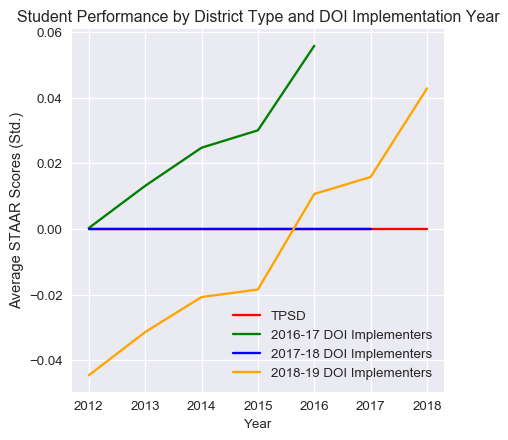

In [13]:
plt.style.use('seaborn')
my_dpi=96
plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)

# Pre
plt.plot(df_control.year, df_control.score_weighted, color = 'red', label = 'TPSD')
plt.plot(df_treat2016[df_treat2016.year <= 2016].year, df_treat2016[df_treat2016.year <= 2016].score_weighted, color = 'green', label = '2016-17 DOI Implementers')
plt.plot(df_treat2017[df_treat2017.year <= 2017].year, df_treat2017[df_treat2017.year <= 2017].score_weighted, color = 'blue', label = '2017-18 DOI Implementers')
plt.plot(df_treat2018[df_treat2018.year <= 2018].year, df_treat2018[df_treat2018.year <= 2018].score_weighted, color = 'orange', label = '2018-19 DOI Implementers')

plt.legend()



plt.ylabel('Average STAAR Scores (Std.)')
plt.title('Student Performance by District Type and DOI Implementation Year')
plt.xlabel('Year', size = 'medium')

#plt.savefig(table_path + 'CITS.png', bbox_inches="tight")

plt.show()
#TODO: WTF the trends and scale

# DOI vs TPS

In [22]:
df_control = pd.DataFrame(data[data.doi == False].groupby(['year'])['avescores'].mean()).reset_index()
df_treat = pd.DataFrame(data[data.doi == True].groupby(['year'])['avescores'].mean()).reset_index()
df_treat

,year,avescores
0,2012,-0.074226
1,2013,0.021222
2,2014,0.137571
3,2015,0.188083
4,2016,0.366305
5,2017,0.353575
6,2018,0.520280


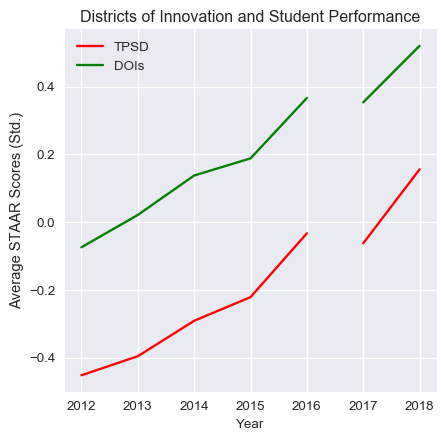

In [23]:
plt.style.use('seaborn')
my_dpi=96
plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)

# Pre
plt.plot(df_control[df_control.year < 2017].year, df_control[df_control.year < 2017].avescores, color = 'red', label = 'TPSD')
plt.plot(df_treat[df_treat.year < 2017].year, df_treat[df_treat.year < 2017].avescores, color = 'green', label = 'DOIs')
plt.legend()

plt.plot(df_control[df_control.year >= 2017].year, df_control[df_control.year >= 2017].avescores, color = 'red')
plt.plot(df_treat[df_treat.year >= 2017].year, df_treat[df_treat.year >= 2017].avescores, color = 'green')





plt.ylabel('Average STAAR Scores (Std.)')
plt.title('Districts of Innovation and Student Performance')
plt.xlabel('Year', size = 'medium')


plt.show()


# Weighted Average

In [24]:
data['score_weighted'] = (data.avescores * data.pswtshare)/100
df_control = pd.DataFrame(data[data.doi == False].groupby(['year'])['score_weighted'].sum()).reset_index()
df_treat = pd.DataFrame(data[data.doi == True].groupby(['year'])['score_weighted'].sum()).reset_index()
df_control

AttributeError: 'DataFrame' object has no attribute 'pswtshare'

In [ ]:
plt.style.use('seaborn')
my_dpi=96
plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)

# Pre
plt.plot(df_control[df_control.year < 2017].year, df_control[df_control.year < 2017].score_weighted, color = 'red', label = 'TPSD')
plt.plot(df_treat[df_treat.year < 2017].year, df_treat[df_treat.year < 2017].score_weighted, color = 'green', label = 'DOIs')
plt.legend()

plt.plot(df_control[df_control.year >= 2017].year, df_control[df_control.year >= 2017].score_weighted, color = 'red')
plt.plot(df_treat[df_treat.year >= 2017].year, df_treat[df_treat.year >= 2017].score_weighted, color = 'green')





plt.ylabel('Average STAAR Scores (Std.)')
plt.title('Districts of Innovation and Student Performance')
plt.xlabel('Year', size = 'medium')


plt.show()

# Demographic Trends

In [ ]:
df_control = pd.DataFrame(data[data.doi == False].groupby(['year'])['students_hisp'].mean()).reset_index()
df_treat2016 = pd.DataFrame(data[data.doi_year == 2016].groupby(['year'])['students_hisp'].mean()).reset_index()
df_treat2017 = pd.DataFrame(data[data.doi_year == 2017].groupby(['year'])['students_hisp'].mean()).reset_index()
df_treat2018 = pd.DataFrame(data[data.doi_year == 2018].groupby(['year'])['students_hisp'].mean()).reset_index()
df_treat2018

In [ ]:
plt.style.use('seaborn')
my_dpi=96
plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)

# Pre
plt.plot(df_control.year, df_control.students_hisp, color = 'red', label = 'TPS')
plt.plot(df_treat2016.year, df_treat2016.students_hisp, color = 'green', label = '2016-17 Implementers')
plt.plot(df_treat2017.year, df_treat2017.students_hisp, color = 'blue', label = '2017-18 Implementers')
plt.plot(df_treat2018.year, df_treat2018.students_hisp, color = 'orange', label = '2018-19 Implementers')

plt.legend()



plt.ylabel('Percent Hispanic')
plt.title('Districts of Innovation and Student Performance')
plt.xlabel('Year', size = 'medium')

#plt.savefig(table_path + 'CITS.png', bbox_inches="tight")

plt.show()

In [ ]:
df_control = pd.DataFrame(data[data.doi == False].groupby(['year'])['students_num'].mean()).reset_index()
df_treat2016 = pd.DataFrame(data[data.doi_year == 2016].groupby(['year'])['students_num'].mean()).reset_index()
df_treat2017 = pd.DataFrame(data[data.doi_year == 2017].groupby(['year'])['students_num'].mean()).reset_index()
df_treat2018 = pd.DataFrame(data[data.doi_year == 2018].groupby(['year'])['students_num'].mean()).reset_index()
df_treat2018

In [ ]:
plt.style.use('seaborn')
my_dpi=96
plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)

# Pre
plt.plot(df_control.year, df_control.students_num, color = 'red', label = 'TPS')
plt.plot(df_treat2016[df_treat2016.year <= 2016].year, df_treat2016[df_treat2016.year <= 2016].students_num, color = 'green', label = '2016-17 Implementers')
plt.plot(df_treat2017[df_treat2017.year <= 2017].year, df_treat2017[df_treat2017.year <= 2017].students_num, color = 'blue', label = '2017-18 Implementers')
plt.plot(df_treat2018[df_treat2018.year <= 2018].year, df_treat2018[df_treat2018.year <= 2018].students_num, color = 'orange', label = '2018-19 Implementers')

plt.legend()



plt.ylabel('Number of Students')
plt.title('Districts of Innovation and Student Performance')
plt.xlabel('Year', size = 'medium')

#plt.savefig(table_path + 'CITS.png', bbox_inches="tight")

plt.show()

In [ ]:
#  Who are 2016-17 implementers
data[(data.doi_year == 2016) & (data.year == 2018)][['distname', 'students_num']]
